In [134]:
using Statistics, Plots, DataFrames
import Distributions: Normal
using Flux
using Flux.Tracker: forwarddiff

targetx = repeat(range(0, stop = 100, length = 69), outer = 2);
targety = vcat(range(0, stop = 100, length = 69), range(100, stop = 0, length = 69))
meanx = mean(targetx)
meany = mean(targety)
stdx = std(targetx)
stdy = std(targety)
meanx, meany

(50.000000000000014, 50.0)

In [135]:
mm = extrema(targety)
t1 = (mm[2]-mm[1])/4+ mm[1]
t2 = (mm[2]-mm[1])/4*2 + mm[1]
t3 = (mm[2]-mm[1])/4*3 + mm[1]
targetx = repeat(range(0, length = 46,stop = 100), outer = 3);
targety = repeat([t1,t2,t3], inner = 46);

targetx = targetx .- mean(targetx) .+ meanx
targety = targety .- mean(targety) .+ meany
mean(targetx), mean(targety), std(targetx), stdx

(50.000000000000014, 50.0, 29.60951601710562, 29.39565896512594)

In [136]:
prex = rand(Normal(0,1), 138).*stdx
prey = rand(Normal(0,1), 138).*stdy

randx = param(prex .- mean(prex) .+ meanx)
randy = param(prey .- mean(prey) .+ meany)
randx, randy

([83.8185, 90.7657, 62.9832, 46.0742, 26.9833, 27.9765, 84.5022, 77.2701, 90.3595, 31.3384  …  57.5129, 73.8394, 22.3961, 47.9934, 13.6241, 28.4524, 93.1427, 46.6447, 75.0506, 61.6595] (tracked), [89.2348, 83.4767, 80.5253, 41.1182, -5.68307, 102.603, -0.506735, 105.26, 105.249, 54.9046  …  52.122, 35.7596, 64.8877, 60.1399, 31.8389, -23.991, 15.3815, 50.8653, 45.705, 19.1338] (tracked))

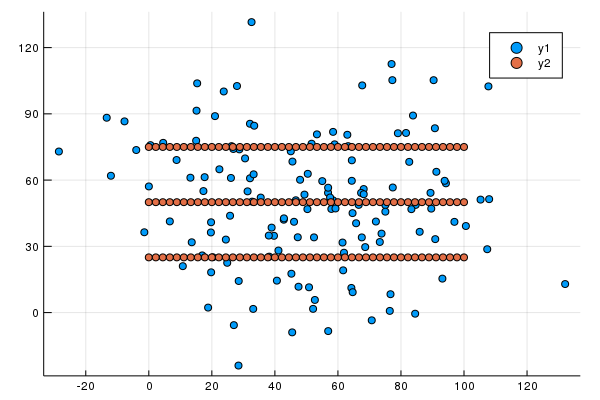

In [137]:
plot(Tracker.data(randx), Tracker.data(randy), seriestype=:scatter)
plot!(targetx, targety, seriestype=:scatter)
#hline!([t1, t2, t3])

In [138]:
mean(Tracker.data.(randx)), mean(Tracker.data.(randy))

(50.000000000000014 (tracked), 50.00000000000001 (tracked))

In [139]:
using Flux.Tracker: update!

loss(targetx, targety) = begin
    index_considered = Int[]
    i = 1
    dist, index = findmin([(randx[i] - targetx)^2 + (randy[i]-targety)^2 for (targetx, targety) in zip(targetx, targety)])
    
    push!(index_considered, index)
    
    for i in 2:length(targetx)
        distances = [(randx[i] - targetx)^2 + (randy[i]-targety)^2 for (targetx, targety) in zip(targetx, targety)]        
        distances[index_considered] .= maximum(distances) + 1 
        
        distadd, index = findmin(distances)
    
        dist += distadd
        push!(index_considered, index)
    end
    
    dist
end

targetx_mean_loss(targetx) = begin
    mean((randx .- mean(targetx)).^2)    
end

targety_mean_loss(targety) = begin
    mean((randy .- mean(targety)).^2)
end

targety_mean_loss (generic function with 1 method)

In [140]:
loss(targetx, targety)
gs = Tracker.gradient(() -> loss(targetx, targety), params(randx, randy))
gs2 = Tracker.gradient(() -> targetx_mean_loss(targetx), params(randx))
gs3 = Tracker.gradient(() -> targety_mean_loss(targety), params(randy))

Grads(...)


In [141]:
delta1 = gs[randx];
delta2 = gs[randy];
delta3 = gs2[randx];
delta4 = gs3[randy];

In [142]:
sign0(x,y) = (x == 0) || (y == 0) || (sign(x) == sign(y))

sign0 (generic function with 1 method)

In [143]:
opt = ADAM()

function ok(targetx, targety, maxiter= 100_000)
    last_loss = float(9999)
    i = 0    
    for j in 1:maxiter
        i += 1
        delta1 = gs[randx];
        delta2 = gs[randy];
        #delta3 = gs2[randx];
        #delta4 = gs3[randy];
        
        #deltais = findall(sign0.(delta1, delta3) .& sign0.(delta2, delta4))
        
        deltai = rand(1:length(targetx))
        #deltai = rand(deltais)
                
        tmp = zeros(Float64, length(targetx))
        tmp[deltai] = 1
        
#         update!(randx, -0.01(delta1+delta3).*tmp)
#         update!(randy, -0.01(delta2+delta4).*tmp)
        update!(randx, -0.01delta1.*tmp)
        update!(randy, -0.01delta2.*tmp)

        new_loss = Tracker.data(loss(targetx, targety))
        if new_loss < last_loss
            last_loss = new_loss
        else
            #println(i)            
            return loss(targetx, targety)
        end
    end
    #println(maxiter)
    return loss(targetx, targety)
end
    
function ok2(targetx, targety, maxiter= 100_000)
    last_loss = float(9999)
    i = 0    
    for j in 1:maxiter
        i += 1
        #delta1 = gs[randx];
        #delta2 = gs[randy];
        delta3 = gs2[randx];
        delta4 = gs3[randy];
        
        #deltais = findall(sign0.(delta1, delta3) .& sign0.(delta2, delta4))
        
        deltai = rand(1:length(targetx))
        #deltai = rand(deltais)
                
        tmp = zeros(Float64, length(targetx))
        tmp[deltai] = 1
        
#         update!(randx, -0.01(delta1+delta3).*tmp)
#         update!(randy, -0.01(delta2+delta4).*tmp)
        update!(randx, -0.01delta3.*tmp)
        update!(randy, -0.01delta4.*tmp)

        new_loss = Tracker.data(loss(targetx, targety))
        if new_loss < last_loss
            last_loss = new_loss
        else
            #println(i)            
            return loss(targetx, targety)
        end
    end
    #println(maxiter)
    return loss(targetx, targety)
end

ok2 (generic function with 2 methods)

In [222]:
loss(targetx, targety)

49280.980360365844 (tracked)

In [ ]:
ok3() = begin
    last_loss = loss(targetx, targety)
    done = false
    while !done
        ok(targetx, targety)
        ok2(targetx, targety)
        new_loss = loss(targetx, targety)
        if new_loss > last_loss
            done = true
        else
            new_loss = last_loss
        end
    end
    loss(targetx, targety)
end

In [ ]:
loss(targetx, targety)

In [ ]:
ok3()

In [132]:
tx = Tracker.data(randx)
ty = Tracker.data(randy)
round.((mean(tx), meanx, mean(ty), meany), digits=2)

(49.95, 50.0, 49.73, 50.0)

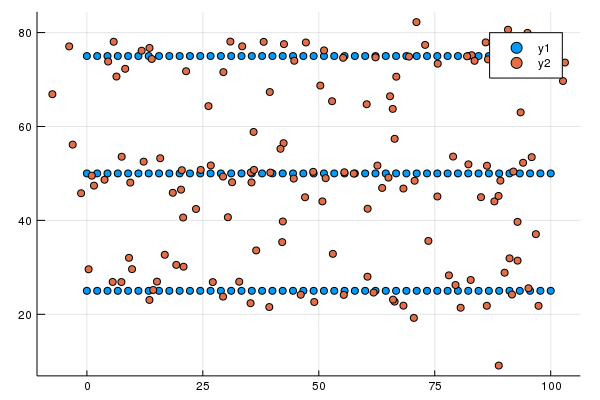

In [133]:
pred = DataFrame(x = Tracker.data(randx), y = Tracker.data(randy))

plot(targetx, targety, seriestype=:scatter)
plot!(pred[:x], pred[:y], seriestype=:scatter)

In [464]:
# targetx = repeat(range(4, length = 46, stop = 14), outer = 3);
# targety = repeat([t1,t2,t3], inner = 46);